In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt, colors
%matplotlib inline
import zipfile
import os
import matplotlib.animation as animation
import torchvision.utils as vutils
import numpy as np
import re
import random
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch import Tensor
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
from torchvision.utils import make_grid
from sklearn.metrics import f1_score
import torchvision.utils as vutils
from collections import OrderedDict
from torch.hub import load_state_dict_from_url

In [2]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

In [3]:
def masked_f1_score(outputs, labels):
    # mins, _ = labels.min(dim=1)
    mask = labels != -1
    f1 = f1_score(torch.squeeze(labels[mask].detach().cpu().float().view(-1)), torch.round(outputs[mask].detach().cpu().float().view(-1)), average="micro")
    return f1

def masked_accuracy(outputs, b_labels):
    mins, _ = b_labels.min(dim=1)
    mask = mins != -1
    accuracy = torch.mean((torch.round(outputs[mask].float()) == b_labels[mask].float()).float())
    return accuracy

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck2(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck2, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        
        self.relu = nn.LeakyReLU(0.2, inplace=False)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
#         out = self.bn3(c3)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
#         out = self.relu(out)

        return out
    
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.maxpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(Bottleneck2, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        self.relu = nn.LeakyReLU(0.2, inplace=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        fm = self.layer4(x)
        x = self.relu(fm)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x, feature_map=fm)

        return x


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=256, ngf=64, ngpu=1):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_dim, ngf * 16, 5, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*8) x 5 x 5
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*4) x 10 x 10
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*2) x 20 x 20
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf) x 40 x 40
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf) x 80 x 80
            nn.ConvTranspose2d( ngf * 1, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 160 x 160
        )

    def forward(self, input):
        return self.main(input.view(input.shape[0], -1, 1, 1))

In [6]:
class DiscriminatorOutput(nn.Module):
    def __init__(self, num_ftrs):
        super(DiscriminatorOutput, self).__init__()
        
        # Two FC Layers to output discriminator and aux output
        self.discriminator = nn.Sequential(
#             nn.Linear(num_ftrs, 1536),
#             nn.BatchNorm1d(num_features=1536),
#             nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(num_ftrs, 1)
        )
        self.aux = nn.Sequential(
#             nn.Linear(num_ftrs, 1536),
#             nn.BatchNorm1d(num_features=1536),
#             nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(num_ftrs, 40)
        )
        self.bn = nn.BatchNorm1d(num_ftrs)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, features, feature_map=None):
        features = self.bn(features)
        output = self.discriminator(features)
        aux_output = self.aux(features)
        return self.sigmoid(output), feature_map, self.sigmoid(aux_output)
    
class EncoderOutput(nn.Module):
    def __init__(self, num_ftrs, latent_dim=256):
        super(EncoderOutput, self).__init__()
        # Two FC Layers to output code and logvar
        self.code = nn.Linear(num_ftrs, latent_dim)
        self.logvar = nn.Linear(num_ftrs, latent_dim)
        
    def forward(self, features, feature_map=None):
        code = self.code(features)
        logvar = self.logvar(features)
        return code, logvar    

In [7]:
class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=5):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        
        self.encoder = resnet50(pretrained=True)
#         num_ftrs = self.encoder.classifier.in_features
#         self.encoder.final_conv = DownsizeBlock(num_ftrs)
        self.encoder.fc = EncoderOutput(num_ftrs=2048, latent_dim=z_size)

        self.decoder = Decoder(latent_dim=self.z_size, ngf=64)
        
        self.discriminator = resnet50(pretrained=True)
#         self.discriminator.avgpool = nn.AdaptiveAvgPool2d((2, 2))
#         num_ftrs = self.discriminator.classifier.in_features
        self.discriminator.fc = DiscriminatorOutput(num_ftrs=2048)
    
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif classname.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)  

    def forward(self, ten, gen_size=10):
        if self.training:
            # save the original images
            ten_original = ten
            
            # encode
            mus, log_variances = self.encoder(ten)
#             print("Encoded")
            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            
            # sample from a gaussian
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            
            # shift and scale using the means and variances
            ten = ten_from_normal * variances + mus

            # decode the tensor
            ten = self.decoder(ten)
#             print("Decoded")
            
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            ten_from_normal = self.decoder(ten_from_normal)
            
            disc_out, fm, aux_out = self.discriminator(torch.cat((ten, ten_original, ten_from_normal), 0))
            return ten, disc_out, aux_out, fm, mus, log_variances

        else:
            if ten is None:
                # just sample and decode

                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                # we need the true variances, not the log one
                variances = torch.exp(log_variances * 0.5)
                # sample from a gaussian

                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                # shift and scale using the means and variances
                ten = ten_from_normal * variances + mus
                # decode the tensor
                ten = self.decoder(ten)
            return ten
   
    @staticmethod
    def weighted_bce(outputs, labels):
        mins, _ = labels.min(dim=1)
        mask = mins != -1
        criterion = torch.nn.BCELoss(reduction="none")
        loss = criterion(torch.squeeze(outputs[mask]), labels[mask])
#         weights = labels + 1
        weights = 1
        loss = (loss * weights).mean()
        return loss

    
    @staticmethod
    def loss(ten_original, ten_predicted, layer_original, layer_predicted, layer_sampled, labels_original,
             labels_predicted, labels_sampled, mus, variances, aux_out, aux_labels):
        """
        :param ten_original: original images
        :param ten_predicted:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predicted.view(len(ten_predicted), -1)) ** 2
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        
        # mse between intermediate layers for both
        mse_1 = torch.sum(0.5*(layer_original - layer_predicted) ** 2, 1) / 2.
        mse_2 = torch.sum(0.5*(layer_original - layer_sampled) ** 2, 1) / 2.
        
        # bce for decoder and discriminator for original,sampled and reconstructed
        # the only excluded is the bce_gen_original
        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)
        bce_dis_recon = -torch.log(1 - labels_predicted+ 1e-3)

        #bce_gen_original = -torch.log(1-labels_original + 1e-3)
        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        bce_gen_recon = -torch.log(labels_predicted+ 1e-3)
        
        aux_loss = VaeGan.weighted_bce(aux_out, aux_labels.float())
        
        return nle, kl, mse_1,mse_2,\
               bce_dis_original, bce_dis_sampled,bce_dis_recon,bce_gen_sampled,bce_gen_recon, aux_loss   

In [8]:
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0

    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [9]:
image_labels = pd.read_csv("list_attr_celeba.csv")
# labels[labels == -1] = 0
feature_columns = image_labels.columns[1:]
num_classes = len(feature_columns)
print(num_classes)
image_labels.replace(-1, 0, inplace=True)
image_labels[feature_columns] = image_labels[feature_columns].astype(float)

class labelledDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # get the label from the data
        targets = image_labels[image_labels['image_id'] == path.split("/")[-1]][['5_o_Clock_Shadow', 'Arched_Eyebrows', 
            'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
            'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
            'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
            'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
            'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
            'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
            'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
            'Wearing_Necklace', 'Wearing_Necktie', 'Young']].values
        
        if len(targets) == 0:
            targets = np.random.binomial(1, 0.5, 40).astype(float)
            # Use -1 if we will be masking items that don't have labels
#             targets = np.array([-1.] * 40).astype(float)
        else:
            targets = targets[0]
        
        return sample, targets
    
BATCH_SIZE = batch_size = 36
data_path = "celeba"
image_size = (160,160)

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
     torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)), 
     torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=2, translate=(0.05,0.05), scale=(0.95,1.05), shear=2, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)),
      torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = labelledDataset(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=7,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=7,
    shuffle=True
)

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params       

40


In [10]:
z_size = 512
recon_level = 5
decay_lr = 0.95
lambda_mse = 1e-6
lr = 1e-4
decay_margin = 1
decay_equilibrium = 1

net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

margin = 0.45
equilibrium = 0.68

# OPTIM-LOSS
# an optimizer for each of the sub-networks, so we can selectively backprop
# optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)

# optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)

optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 65615302.64it/s]


In [11]:
def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params        

# print("Autoencoder Params:", count_params(netG))
print("Encoder Params:", count_params(net.encoder))
print("Decoder Params:", count_params(net.decoder))
print("Discriminator Params:", count_params(net.discriminator))

Encoder Params: 25606208
Decoder Params: 24255360
Discriminator Params: 23596137


In [14]:
model_save_path = "vaegan_resnet50_b.pt"
disc_opt_save_path = "vaegan_resnet50_opt_disc_b.pt"
enc_opt_save_path = "vaegan_resnet50_opt_enc_b.pt"
dec_opt_save_path = "vaegan_resnet50_opt_dec_b.pt"

In [15]:
net.load_state_dict(torch.load(model_save_path))
optimizer_encoder.load_state_dict(torch.load(enc_opt_save_path))
optimizer_decoder.load_state_dict(torch.load(dec_opt_save_path))
optimizer_discriminator.load_state_dict(torch.load(disc_opt_save_path))

In [20]:
decay_mse = 1
decay_equilibrium = 1
margin = 0.35
equilibrium = 0.68

def train(net, n_epochs=5, train_loader=train_loader, margin=margin, plot_images=1000):
    lambda_mse = 1e-6
    lambda_aux = 0.25
    decay_mse = 1
    decay_equilibrium = 1
    equilibrium = 0.68

    try:
        for i in range(n_epochs):
            # reset rolling average
            loss_nle_mean = RollingMeasure()
            loss_encoder_mean = RollingMeasure()
            loss_decoder_mean = RollingMeasure()
            loss_discriminator_mean = RollingMeasure()
            loss_reconstruction_layer_mean = RollingMeasure()
            loss_kld_mean = RollingMeasure()
            gan_gen_eq_mean = RollingMeasure()
            gan_dis_eq_mean = RollingMeasure()
            aux_f1 = RollingMeasure()
            
            #print("LR:{}".format(lr_encoder.get_lr()))

            # for each batch
            for j, (data_batch,aux_labels) in enumerate(train_loader):
                # set to train mode
                train_batch = len(data_batch)
                net.train()
                # target and input are the same images
                data_in = Variable(data_batch, requires_grad=False).float().cuda()
                data_target = data_in.clone()
                aux_labels = aux_labels.cuda()

                # get output
                out, out_labels, aux_out, out_layer, mus, variances = net(data_in)

                # split so we can get the different parts
                out_layer_predicted = out_layer[:train_batch]
                out_layer_original = out_layer[train_batch:-train_batch]
                out_layer_sampled = out_layer[-train_batch:]

                #labels
                out_labels_predicted = out_labels[:train_batch]
                out_labels_original = out_labels[train_batch:-train_batch]
                out_labels_sampled = out_labels[-train_batch:]

                aux_out = aux_out[train_batch:-train_batch]
                # loss, nothing special here
                nle_value, kl_value, mse_value_1,mse_value_2, bce_dis_original_value, bce_dis_sampled_value, \
                bce_dis_predicted_value,bce_gen_sampled_value,bce_gen_predicted_value, aux_loss = VaeGan.loss(data_target, out, out_layer_original,
                                                                              out_layer_predicted,out_layer_sampled, out_labels_original,
                                                                              out_labels_predicted,out_labels_sampled, mus,
                                                                              variances, aux_out, aux_labels)
                # THIS IS THE MOST IMPORTANT PART OF THE CODE
                loss_encoder = torch.sum(kl_value)+torch.sum(mse_value_1) # + torch.sum(mse_value_2)
                loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value)+ torch.sum(bce_dis_predicted_value) + (lambda_aux * aux_loss)
                loss_decoder = torch.sum(bce_gen_sampled_value) + torch.sum(bce_gen_predicted_value)
                loss_decoder = torch.sum(lambda_mse / 2 * mse_value_1) + torch.sum(lambda_mse / 10 * mse_value_2) + (1.0 - lambda_mse) * loss_decoder

                # register mean values of the losses for logging
                loss_nle_mean(0)
                loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)).cpu().item())
                loss_decoder_mean((torch.mean(lambda_mse * mse_value_1 / 2) + torch.mean(lambda_mse * mse_value_2 / 10) + (1 - lambda_mse) * (torch.mean(bce_gen_predicted_value) + torch.mean(bce_gen_sampled_value))).cpu().item())

                aux_f1(masked_accuracy(aux_out, aux_labels))

                loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value_1)+ torch.mean(mse_value_2)).cpu().item())
                loss_reconstruction_layer_mean((torch.mean(mse_value_1)+torch.mean(mse_value_2)).cpu().item())
                loss_kld_mean(torch.mean(kl_value).data.cpu().item())
                
                # selectively disable the decoder of the discriminator if they are unbalanced
                train_dis = True
                train_dec = True
                
                if torch.mean(bce_dis_original_value).item() < equilibrium-margin or torch.mean(bce_dis_sampled_value).item() < equilibrium-margin:
                    train_dis = False
                if torch.mean(bce_dis_original_value).item() > equilibrium+margin or torch.mean(bce_dis_sampled_value).item() > equilibrium+margin:
                    train_dec = False
                if train_dec is False and train_dis is False:
                    train_dis = True
                    train_dec = True

                #aggiungo log
                if train_dis:
                    gan_dis_eq_mean(1.0)
                else:
                    gan_dis_eq_mean(0.0)

                if train_dec:
                    gan_gen_eq_mean(1.0)
                else:
                    gan_gen_eq_mean(0.0)

                # BACKPROP
                # clean grads
                net.zero_grad()
                # encoder
                loss_encoder.backward(retain_graph=True)
                # someone likes to clamp the grad here
                #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
                # update parameters
                optimizer_encoder.step()
                # clean others, so they are not afflicted by encoder loss
                net.zero_grad()
                #decoder
                if train_dec:
                    loss_decoder.backward(retain_graph=True)
                    #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                    optimizer_decoder.step()
                    #clean the discriminator
                    net.discriminator.zero_grad()
                #discriminator
                if train_dis:
                    loss_discriminator.backward()
                    #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                    optimizer_discriminator.step()

                if j % 100 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_Dec: %.4f\tAux F1: %.4f\tLoss_Enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                          % (i, n_epochs, j, len(train_loader),
                              loss_discriminator_mean.measure,  loss_decoder_mean.measure, aux_f1.measure, loss_encoder_mean.measure, out_labels_original.mean().item(), out_labels_predicted.mean().item()))
                if j % plot_images == 0 and j > 0:
                    with torch.no_grad():
                        out = (out * 0.5) + 0.5
                        fig, ax = plt.subplots(1, 2, figsize=(7,7))
                        ax[0].imshow(np.transpose(vutils.make_grid(out[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                        ax[1].imshow(np.transpose(vutils.make_grid(data_in[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                        plt.show()

            torch.save(net.state_dict(), model_save_path)
            torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
            torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
            torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

            lr_encoder.step()
            lr_decoder.step()
            lr_discriminator.step()
            margin *=decay_margin
            equilibrium *=decay_equilibrium
            #margin non puo essere piu alto di equilibrium
            if margin > equilibrium:
                equilibrium = margin
            lambda_mse *=decay_mse
            if lambda_mse > 1:
                lambda_mse=1

            # plot some sample images
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            out = (out * 0.5) + 0.5
            ax[0].imshow(np.transpose(vutils.make_grid(out.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(data_batch.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()   
            
    except KeyboardInterrupt:
        print("Interrupting... Saving model...")
        torch.save(net.state_dict(), model_save_path)
        torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
        torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
        torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

[0/5][0/5628]	Loss_D: 0.8019	Loss_Dec: 3.6142	Aux F1: 0.8063	Loss_Enc: 7991.5176	D(x): 0.5980	D(G(z)): 0.2320
[0/5][100/5628]	Loss_D: 0.9224	Loss_Dec: 3.3150	Aux F1: 0.8040	Loss_Enc: 7725.1368	D(x): 0.5738	D(G(z)): 0.2737
[0/5][200/5628]	Loss_D: 0.8985	Loss_Dec: 3.3208	Aux F1: 0.8101	Loss_Enc: 7855.7855	D(x): 0.4315	D(G(z)): 0.3314
[0/5][300/5628]	Loss_D: 0.8977	Loss_Dec: 3.2860	Aux F1: 0.8131	Loss_Enc: 8042.3920	D(x): 0.4287	D(G(z)): 0.3838
[0/5][400/5628]	Loss_D: 0.8819	Loss_Dec: 3.3230	Aux F1: 0.8151	Loss_Enc: 8105.2121	D(x): 0.5735	D(G(z)): 0.2410
[0/5][500/5628]	Loss_D: 0.8780	Loss_Dec: 3.3565	Aux F1: 0.8153	Loss_Enc: 8071.5063	D(x): 0.5351	D(G(z)): 0.3015


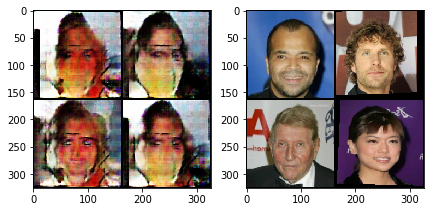

[0/5][600/5628]	Loss_D: 0.8870	Loss_Dec: 3.3432	Aux F1: 0.8163	Loss_Enc: 8094.7051	D(x): 0.5362	D(G(z)): 0.2866
[0/5][700/5628]	Loss_D: 0.8729	Loss_Dec: 3.3763	Aux F1: 0.8172	Loss_Enc: 8079.5594	D(x): 0.7440	D(G(z)): 0.1961
[0/5][800/5628]	Loss_D: 0.8403	Loss_Dec: 3.4814	Aux F1: 0.8168	Loss_Enc: 7972.5068	D(x): 0.7761	D(G(z)): 0.1834
[0/5][900/5628]	Loss_D: 0.8253	Loss_Dec: 3.5487	Aux F1: 0.8161	Loss_Enc: 7878.1484	D(x): 0.7204	D(G(z)): 0.2648
[0/5][1000/5628]	Loss_D: 0.8212	Loss_Dec: 3.5849	Aux F1: 0.8161	Loss_Enc: 7824.6793	D(x): 0.6039	D(G(z)): 0.2911


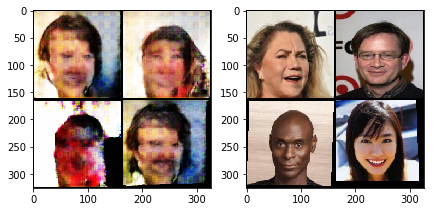

[0/5][1100/5628]	Loss_D: 0.8118	Loss_Dec: 3.6130	Aux F1: 0.8160	Loss_Enc: 7774.1766	D(x): 0.5446	D(G(z)): 0.4009
[0/5][1200/5628]	Loss_D: 0.8068	Loss_Dec: 3.6240	Aux F1: 0.8161	Loss_Enc: 7731.7059	D(x): 0.6855	D(G(z)): 0.3161
[0/5][1300/5628]	Loss_D: 0.8115	Loss_Dec: 3.6142	Aux F1: 0.8165	Loss_Enc: 7702.9226	D(x): 0.5904	D(G(z)): 0.2635
[0/5][1400/5628]	Loss_D: 0.8105	Loss_Dec: 3.6130	Aux F1: 0.8168	Loss_Enc: 7663.3712	D(x): 0.5862	D(G(z)): 0.3017
[0/5][1500/5628]	Loss_D: 0.8073	Loss_Dec: 3.6251	Aux F1: 0.8164	Loss_Enc: 7607.6120	D(x): 0.6927	D(G(z)): 0.2669


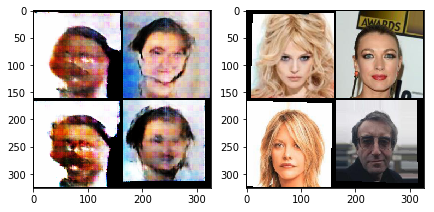

[0/5][1600/5628]	Loss_D: 0.8065	Loss_Dec: 3.6307	Aux F1: 0.8167	Loss_Enc: 7557.7586	D(x): 0.5157	D(G(z)): 0.3011
[0/5][1700/5628]	Loss_D: 0.8050	Loss_Dec: 3.6343	Aux F1: 0.8173	Loss_Enc: 7525.3652	D(x): 0.5805	D(G(z)): 0.3184
[0/5][1800/5628]	Loss_D: 0.8043	Loss_Dec: 3.6371	Aux F1: 0.8173	Loss_Enc: 7481.5300	D(x): 0.4466	D(G(z)): 0.3597
[0/5][1900/5628]	Loss_D: 0.8041	Loss_Dec: 3.6402	Aux F1: 0.8166	Loss_Enc: 7433.0472	D(x): 0.6330	D(G(z)): 0.2215
[0/5][2000/5628]	Loss_D: 0.8069	Loss_Dec: 3.6363	Aux F1: 0.8164	Loss_Enc: 7384.4519	D(x): 0.4970	D(G(z)): 0.3264


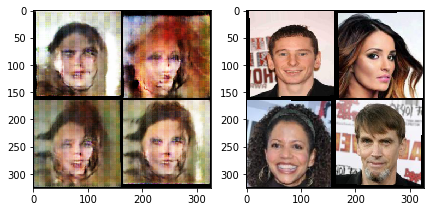

[0/5][2100/5628]	Loss_D: 0.8110	Loss_Dec: 3.6297	Aux F1: 0.8158	Loss_Enc: 7365.1723	D(x): 0.4966	D(G(z)): 0.2830
[0/5][2200/5628]	Loss_D: 0.8144	Loss_Dec: 3.6237	Aux F1: 0.8159	Loss_Enc: 7357.5146	D(x): 0.5159	D(G(z)): 0.2608
[0/5][2300/5628]	Loss_D: 0.8168	Loss_Dec: 3.6214	Aux F1: 0.8159	Loss_Enc: 7343.1861	D(x): 0.6624	D(G(z)): 0.2380
[0/5][2400/5628]	Loss_D: 0.8194	Loss_Dec: 3.6183	Aux F1: 0.8161	Loss_Enc: 7327.0550	D(x): 0.5863	D(G(z)): 0.3045
[0/5][2500/5628]	Loss_D: 0.8241	Loss_Dec: 3.6091	Aux F1: 0.8164	Loss_Enc: 7320.2064	D(x): 0.4642	D(G(z)): 0.3042


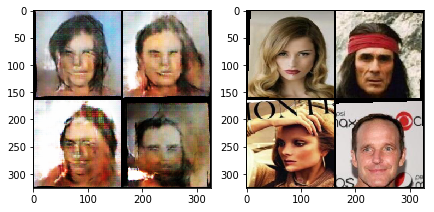

[0/5][2600/5628]	Loss_D: 0.8251	Loss_Dec: 3.6054	Aux F1: 0.8166	Loss_Enc: 7308.4968	D(x): 0.5690	D(G(z)): 0.3188
[0/5][2700/5628]	Loss_D: 0.8274	Loss_Dec: 3.6005	Aux F1: 0.8169	Loss_Enc: 7293.0124	D(x): 0.6362	D(G(z)): 0.4384
[0/5][2800/5628]	Loss_D: 0.8264	Loss_Dec: 3.6035	Aux F1: 0.8169	Loss_Enc: 7284.2142	D(x): 0.4934	D(G(z)): 0.2655
[0/5][2900/5628]	Loss_D: 0.8274	Loss_Dec: 3.6006	Aux F1: 0.8170	Loss_Enc: 7263.4003	D(x): 0.5470	D(G(z)): 0.3599
[0/5][3000/5628]	Loss_D: 0.8285	Loss_Dec: 3.5970	Aux F1: 0.8173	Loss_Enc: 7248.8207	D(x): 0.5760	D(G(z)): 0.3138


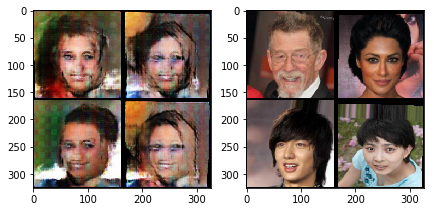

[0/5][3100/5628]	Loss_D: 0.8306	Loss_Dec: 3.5883	Aux F1: 0.8173	Loss_Enc: 7240.9345	D(x): 0.4921	D(G(z)): 0.3004
[0/5][3200/5628]	Loss_D: 0.8333	Loss_Dec: 3.5799	Aux F1: 0.8174	Loss_Enc: 7239.0132	D(x): 0.4134	D(G(z)): 0.3668
[0/5][3300/5628]	Loss_D: 0.8367	Loss_Dec: 3.5702	Aux F1: 0.8176	Loss_Enc: 7244.9455	D(x): 0.5981	D(G(z)): 0.3160
[0/5][3400/5628]	Loss_D: 0.8396	Loss_Dec: 3.5613	Aux F1: 0.8177	Loss_Enc: 7245.2389	D(x): 0.4698	D(G(z)): 0.4202
[0/5][3500/5628]	Loss_D: 0.8393	Loss_Dec: 3.5611	Aux F1: 0.8177	Loss_Enc: 7243.9390	D(x): 0.6513	D(G(z)): 0.1974


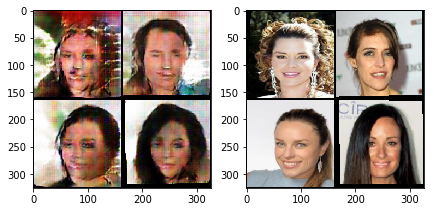

[0/5][3600/5628]	Loss_D: 0.8382	Loss_Dec: 3.5608	Aux F1: 0.8179	Loss_Enc: 7238.0285	D(x): 0.5673	D(G(z)): 0.3449
[0/5][3700/5628]	Loss_D: 0.8392	Loss_Dec: 3.5551	Aux F1: 0.8178	Loss_Enc: 7236.2449	D(x): 0.5592	D(G(z)): 0.2606
[0/5][3800/5628]	Loss_D: 0.8395	Loss_Dec: 3.5540	Aux F1: 0.8180	Loss_Enc: 7226.6275	D(x): 0.5437	D(G(z)): 0.3345
[0/5][3900/5628]	Loss_D: 0.8425	Loss_Dec: 3.5479	Aux F1: 0.8181	Loss_Enc: 7233.3158	D(x): 0.4471	D(G(z)): 0.3241
[0/5][4000/5628]	Loss_D: 0.8450	Loss_Dec: 3.5415	Aux F1: 0.8183	Loss_Enc: 7248.3897	D(x): 0.5642	D(G(z)): 0.2790


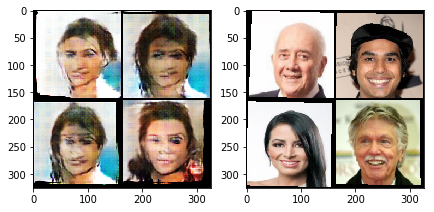

[0/5][4100/5628]	Loss_D: 0.8473	Loss_Dec: 3.5367	Aux F1: 0.8185	Loss_Enc: 7258.8836	D(x): 0.5795	D(G(z)): 0.3000
[0/5][4200/5628]	Loss_D: 0.8487	Loss_Dec: 3.5304	Aux F1: 0.8186	Loss_Enc: 7265.8463	D(x): 0.5861	D(G(z)): 0.4116
[0/5][4300/5628]	Loss_D: 0.8521	Loss_Dec: 3.5209	Aux F1: 0.8188	Loss_Enc: 7275.3540	D(x): 0.4335	D(G(z)): 0.3706
[0/5][4400/5628]	Loss_D: 0.8551	Loss_Dec: 3.5121	Aux F1: 0.8189	Loss_Enc: 7287.1971	D(x): 0.5956	D(G(z)): 0.3117
[0/5][4500/5628]	Loss_D: 0.8572	Loss_Dec: 3.5045	Aux F1: 0.8192	Loss_Enc: 7300.9285	D(x): 0.4164	D(G(z)): 0.3342


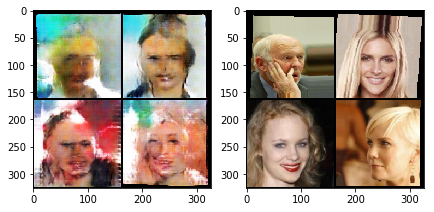

[0/5][4600/5628]	Loss_D: 0.8599	Loss_Dec: 3.4978	Aux F1: 0.8193	Loss_Enc: 7314.5428	D(x): 0.4466	D(G(z)): 0.3249
[0/5][4700/5628]	Loss_D: 0.8619	Loss_Dec: 3.4913	Aux F1: 0.8195	Loss_Enc: 7320.6503	D(x): 0.5644	D(G(z)): 0.2864
[0/5][4800/5628]	Loss_D: 0.8643	Loss_Dec: 3.4833	Aux F1: 0.8195	Loss_Enc: 7319.3220	D(x): 0.4331	D(G(z)): 0.3633
[0/5][4900/5628]	Loss_D: 0.8659	Loss_Dec: 3.4773	Aux F1: 0.8196	Loss_Enc: 7319.1887	D(x): 0.4797	D(G(z)): 0.3176
[0/5][5000/5628]	Loss_D: 0.8678	Loss_Dec: 3.4711	Aux F1: 0.8198	Loss_Enc: 7322.5495	D(x): 0.4041	D(G(z)): 0.3979


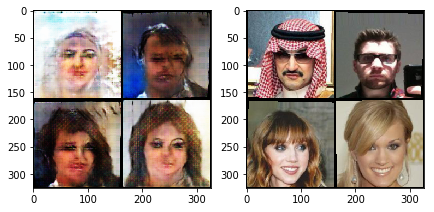

[0/5][5100/5628]	Loss_D: 0.8698	Loss_Dec: 3.4657	Aux F1: 0.8198	Loss_Enc: 7324.9311	D(x): 0.4117	D(G(z)): 0.3828
[0/5][5200/5628]	Loss_D: 0.8720	Loss_Dec: 3.4590	Aux F1: 0.8199	Loss_Enc: 7331.7515	D(x): 0.4831	D(G(z)): 0.3390
[0/5][5300/5628]	Loss_D: 0.8734	Loss_Dec: 3.4534	Aux F1: 0.8200	Loss_Enc: 7339.3357	D(x): 0.5931	D(G(z)): 0.2651
[0/5][5400/5628]	Loss_D: 0.8751	Loss_Dec: 3.4468	Aux F1: 0.8201	Loss_Enc: 7342.2590	D(x): 0.4728	D(G(z)): 0.3480
[0/5][5500/5628]	Loss_D: 0.8774	Loss_Dec: 3.4397	Aux F1: 0.8201	Loss_Enc: 7351.8117	D(x): 0.4822	D(G(z)): 0.4022


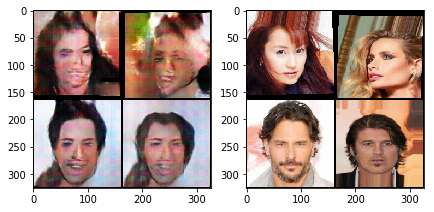

[0/5][5600/5628]	Loss_D: 0.8791	Loss_Dec: 3.4335	Aux F1: 0.8201	Loss_Enc: 7353.2616	D(x): 0.4633	D(G(z)): 0.3590


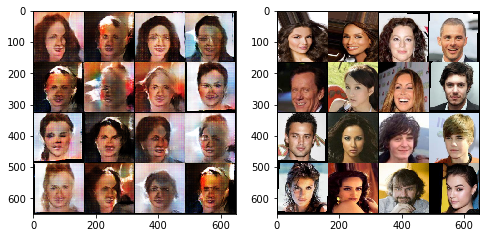

[1/5][0/5628]	Loss_D: 1.1838	Loss_Dec: 2.9382	Aux F1: 0.7924	Loss_Enc: 6785.7568	D(x): 0.4537	D(G(z)): 0.3289
[1/5][100/5628]	Loss_D: 0.9412	Loss_Dec: 3.2496	Aux F1: 0.8252	Loss_Enc: 7312.2167	D(x): 0.5976	D(G(z)): 0.2906
[1/5][200/5628]	Loss_D: 0.8878	Loss_Dec: 3.2873	Aux F1: 0.8231	Loss_Enc: 7159.9296	D(x): 0.4971	D(G(z)): 0.3066
[1/5][300/5628]	Loss_D: 0.8888	Loss_Dec: 3.2744	Aux F1: 0.8218	Loss_Enc: 7052.9761	D(x): 0.4718	D(G(z)): 0.3367
[1/5][400/5628]	Loss_D: 0.8839	Loss_Dec: 3.2805	Aux F1: 0.8218	Loss_Enc: 7055.9052	D(x): 0.5084	D(G(z)): 0.3287
[1/5][500/5628]	Loss_D: 0.8862	Loss_Dec: 3.2941	Aux F1: 0.8216	Loss_Enc: 7011.3221	D(x): 0.4603	D(G(z)): 0.3984


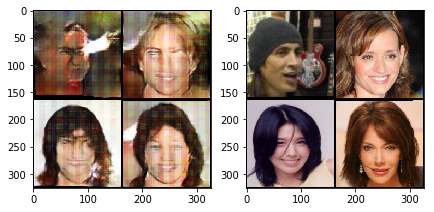

[1/5][600/5628]	Loss_D: 0.8948	Loss_Dec: 3.2808	Aux F1: 0.8218	Loss_Enc: 7045.3920	D(x): 0.4707	D(G(z)): 0.3202
[1/5][700/5628]	Loss_D: 0.9151	Loss_Dec: 3.2492	Aux F1: 0.8219	Loss_Enc: 7086.8735	D(x): 0.4880	D(G(z)): 0.3515
[1/5][800/5628]	Loss_D: 0.9352	Loss_Dec: 3.2105	Aux F1: 0.8224	Loss_Enc: 7167.7550	D(x): 0.4319	D(G(z)): 0.3588
[1/5][900/5628]	Loss_D: 0.9464	Loss_Dec: 3.1811	Aux F1: 0.8230	Loss_Enc: 7259.3125	D(x): 0.5789	D(G(z)): 0.2998
[1/5][1000/5628]	Loss_D: 0.9499	Loss_Dec: 3.1683	Aux F1: 0.8232	Loss_Enc: 7300.4034	D(x): 0.5042	D(G(z)): 0.3696


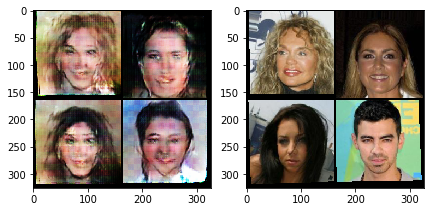

[1/5][1100/5628]	Loss_D: 0.9563	Loss_Dec: 3.1527	Aux F1: 0.8234	Loss_Enc: 7353.4133	D(x): 0.4371	D(G(z)): 0.3799
[1/5][1200/5628]	Loss_D: 0.9642	Loss_Dec: 3.1296	Aux F1: 0.8237	Loss_Enc: 7433.3161	D(x): 0.5063	D(G(z)): 0.3808
[1/5][1300/5628]	Loss_D: 0.9708	Loss_Dec: 3.1121	Aux F1: 0.8236	Loss_Enc: 7468.3294	D(x): 0.4569	D(G(z)): 0.3314
[1/5][1400/5628]	Loss_D: 0.9700	Loss_Dec: 3.1062	Aux F1: 0.8232	Loss_Enc: 7461.4270	D(x): 0.5157	D(G(z)): 0.3101
[1/5][1500/5628]	Loss_D: 0.9640	Loss_Dec: 3.1107	Aux F1: 0.8231	Loss_Enc: 7406.6380	D(x): 0.5074	D(G(z)): 0.3082


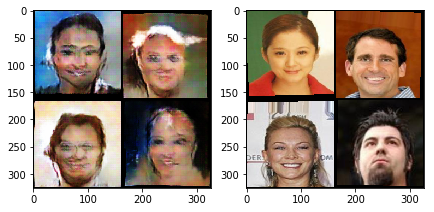

[1/5][1600/5628]	Loss_D: 0.9649	Loss_Dec: 3.1083	Aux F1: 0.8231	Loss_Enc: 7392.1257	D(x): 0.4349	D(G(z)): 0.3222
[1/5][1700/5628]	Loss_D: 0.9675	Loss_Dec: 3.0999	Aux F1: 0.8233	Loss_Enc: 7401.5314	D(x): 0.5277	D(G(z)): 0.3195
[1/5][1800/5628]	Loss_D: 0.9682	Loss_Dec: 3.0957	Aux F1: 0.8236	Loss_Enc: 7406.2487	D(x): 0.5110	D(G(z)): 0.3169
[1/5][1900/5628]	Loss_D: 0.9711	Loss_Dec: 3.0878	Aux F1: 0.8239	Loss_Enc: 7413.8539	D(x): 0.5239	D(G(z)): 0.3683
[1/5][2000/5628]	Loss_D: 0.9725	Loss_Dec: 3.0822	Aux F1: 0.8241	Loss_Enc: 7413.4331	D(x): 0.5241	D(G(z)): 0.3438


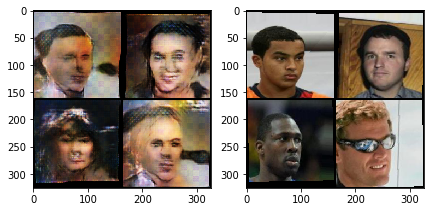

[1/5][2100/5628]	Loss_D: 0.9736	Loss_Dec: 3.0780	Aux F1: 0.8243	Loss_Enc: 7392.4674	D(x): 0.4903	D(G(z)): 0.3831
[1/5][2200/5628]	Loss_D: 0.9738	Loss_Dec: 3.0742	Aux F1: 0.8244	Loss_Enc: 7394.0107	D(x): 0.4368	D(G(z)): 0.3876
[1/5][2300/5628]	Loss_D: 0.9758	Loss_Dec: 3.0681	Aux F1: 0.8246	Loss_Enc: 7412.1652	D(x): 0.5045	D(G(z)): 0.3066
[1/5][2400/5628]	Loss_D: 0.9773	Loss_Dec: 3.0634	Aux F1: 0.8246	Loss_Enc: 7429.5147	D(x): 0.5117	D(G(z)): 0.3292
[1/5][2500/5628]	Loss_D: 0.9791	Loss_Dec: 3.0580	Aux F1: 0.8246	Loss_Enc: 7457.3657	D(x): 0.6134	D(G(z)): 0.2541


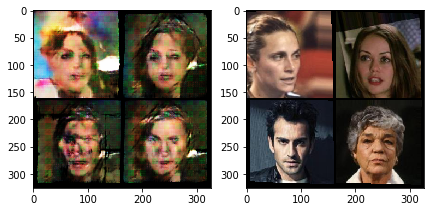

[1/5][2600/5628]	Loss_D: 0.9800	Loss_Dec: 3.0531	Aux F1: 0.8245	Loss_Enc: 7473.5790	D(x): 0.4979	D(G(z)): 0.3580
[1/5][2700/5628]	Loss_D: 0.9813	Loss_Dec: 3.0469	Aux F1: 0.8246	Loss_Enc: 7492.4401	D(x): 0.4598	D(G(z)): 0.3901
[1/5][2800/5628]	Loss_D: 0.9821	Loss_Dec: 3.0421	Aux F1: 0.8247	Loss_Enc: 7506.0520	D(x): 0.5668	D(G(z)): 0.4186
[1/5][2900/5628]	Loss_D: 0.9822	Loss_Dec: 3.0389	Aux F1: 0.8249	Loss_Enc: 7507.9860	D(x): 0.4699	D(G(z)): 0.3703
[1/5][3000/5628]	Loss_D: 0.9832	Loss_Dec: 3.0353	Aux F1: 0.8248	Loss_Enc: 7490.8946	D(x): 0.4928	D(G(z)): 0.3310


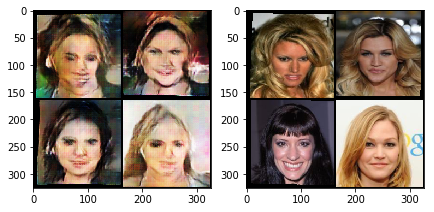

[1/5][3100/5628]	Loss_D: 0.9852	Loss_Dec: 3.0311	Aux F1: 0.8249	Loss_Enc: 7495.1526	D(x): 0.5059	D(G(z)): 0.2582
[1/5][3200/5628]	Loss_D: 0.9862	Loss_Dec: 3.0280	Aux F1: 0.8250	Loss_Enc: 7508.7191	D(x): 0.5502	D(G(z)): 0.3206
[1/5][3300/5628]	Loss_D: 0.9875	Loss_Dec: 3.0244	Aux F1: 0.8251	Loss_Enc: 7522.2137	D(x): 0.5405	D(G(z)): 0.2880
[1/5][3400/5628]	Loss_D: 0.9870	Loss_Dec: 3.0252	Aux F1: 0.8251	Loss_Enc: 7525.5005	D(x): 0.4402	D(G(z)): 0.3827
[1/5][3500/5628]	Loss_D: 0.9863	Loss_Dec: 3.0266	Aux F1: 0.8251	Loss_Enc: 7542.7738	D(x): 0.6008	D(G(z)): 0.3312


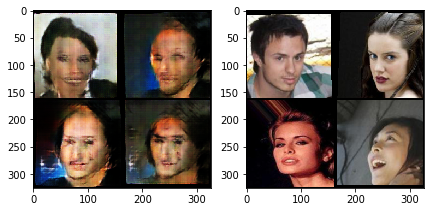

[1/5][3600/5628]	Loss_D: 0.9847	Loss_Dec: 3.0300	Aux F1: 0.8251	Loss_Enc: 7536.1225	D(x): 0.5870	D(G(z)): 0.2877
[1/5][3700/5628]	Loss_D: 0.9829	Loss_Dec: 3.0337	Aux F1: 0.8251	Loss_Enc: 7525.3043	D(x): 0.5434	D(G(z)): 0.3195
[1/5][3800/5628]	Loss_D: 0.9815	Loss_Dec: 3.0383	Aux F1: 0.8251	Loss_Enc: 7507.1878	D(x): 0.5399	D(G(z)): 0.2871
[1/5][3900/5628]	Loss_D: 0.9805	Loss_Dec: 3.0412	Aux F1: 0.8249	Loss_Enc: 7476.1069	D(x): 0.5306	D(G(z)): 0.3449
[1/5][4000/5628]	Loss_D: 0.9811	Loss_Dec: 3.0421	Aux F1: 0.8249	Loss_Enc: 7447.9766	D(x): 0.6203	D(G(z)): 0.3510


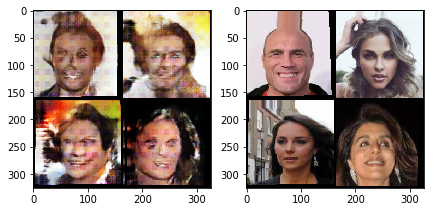

[1/5][4100/5628]	Loss_D: 0.9787	Loss_Dec: 3.0470	Aux F1: 0.8251	Loss_Enc: 7437.0129	D(x): 0.6010	D(G(z)): 0.4227
[1/5][4200/5628]	Loss_D: 0.9768	Loss_Dec: 3.0504	Aux F1: 0.8252	Loss_Enc: 7427.8934	D(x): 0.4889	D(G(z)): 0.3392
[1/5][4300/5628]	Loss_D: 0.9779	Loss_Dec: 3.0481	Aux F1: 0.8254	Loss_Enc: 7429.7598	D(x): 0.4069	D(G(z)): 0.3565
[1/5][4400/5628]	Loss_D: 0.9775	Loss_Dec: 3.0477	Aux F1: 0.8255	Loss_Enc: 7423.8680	D(x): 0.5890	D(G(z)): 0.3261
[1/5][4500/5628]	Loss_D: 0.9766	Loss_Dec: 3.0483	Aux F1: 0.8255	Loss_Enc: 7414.2141	D(x): 0.3720	D(G(z)): 0.3632


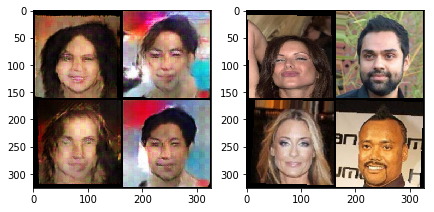

[1/5][4600/5628]	Loss_D: 0.9776	Loss_Dec: 3.0467	Aux F1: 0.8256	Loss_Enc: 7422.7829	D(x): 0.5459	D(G(z)): 0.3147
[1/5][4700/5628]	Loss_D: 0.9775	Loss_Dec: 3.0465	Aux F1: 0.8257	Loss_Enc: 7423.2889	D(x): 0.5266	D(G(z)): 0.2906
[1/5][4800/5628]	Loss_D: 0.9763	Loss_Dec: 3.0495	Aux F1: 0.8258	Loss_Enc: 7411.2891	D(x): 0.6554	D(G(z)): 0.2173
[1/5][4900/5628]	Loss_D: 0.9767	Loss_Dec: 3.0501	Aux F1: 0.8258	Loss_Enc: 7400.7223	D(x): 0.4943	D(G(z)): 0.4343
[1/5][5000/5628]	Loss_D: 0.9757	Loss_Dec: 3.0516	Aux F1: 0.8259	Loss_Enc: 7389.1808	D(x): 0.5760	D(G(z)): 0.3116


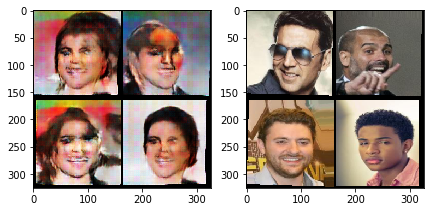

[1/5][5100/5628]	Loss_D: 0.9763	Loss_Dec: 3.0505	Aux F1: 0.8259	Loss_Enc: 7387.7314	D(x): 0.5353	D(G(z)): 0.2763
[1/5][5200/5628]	Loss_D: 0.9756	Loss_Dec: 3.0519	Aux F1: 0.8260	Loss_Enc: 7402.3515	D(x): 0.4780	D(G(z)): 0.2909
[1/5][5300/5628]	Loss_D: 0.9749	Loss_Dec: 3.0531	Aux F1: 0.8261	Loss_Enc: 7407.3986	D(x): 0.5263	D(G(z)): 0.2786
[1/5][5400/5628]	Loss_D: 0.9742	Loss_Dec: 3.0570	Aux F1: 0.8260	Loss_Enc: 7396.5763	D(x): 0.4229	D(G(z)): 0.3879
[1/5][5500/5628]	Loss_D: 0.9747	Loss_Dec: 3.0562	Aux F1: 0.8259	Loss_Enc: 7377.4691	D(x): 0.5963	D(G(z)): 0.2857


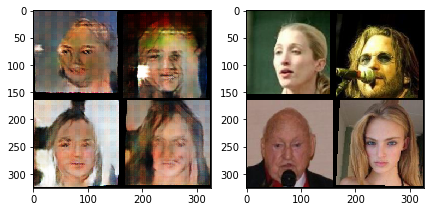

[1/5][5600/5628]	Loss_D: 0.9751	Loss_Dec: 3.0554	Aux F1: 0.8259	Loss_Enc: 7344.7304	D(x): 0.5022	D(G(z)): 0.3583


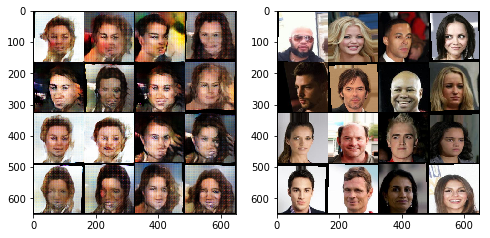

[2/5][0/5628]	Loss_D: 1.0807	Loss_Dec: 2.8531	Aux F1: 0.8403	Loss_Enc: 5765.8740	D(x): 0.4603	D(G(z)): 0.3274
[2/5][100/5628]	Loss_D: 1.0329	Loss_Dec: 2.9485	Aux F1: 0.8245	Loss_Enc: 5457.2400	D(x): 0.4234	D(G(z)): 0.3111
[2/5][200/5628]	Loss_D: 1.0258	Loss_Dec: 2.9585	Aux F1: 0.8258	Loss_Enc: 5262.7928	D(x): 0.4768	D(G(z)): 0.3534
[2/5][300/5628]	Loss_D: 1.0270	Loss_Dec: 2.9436	Aux F1: 0.8263	Loss_Enc: 5200.4610	D(x): 0.4545	D(G(z)): 0.3340
[2/5][400/5628]	Loss_D: 1.0252	Loss_Dec: 2.9297	Aux F1: 0.8262	Loss_Enc: 5234.8605	D(x): 0.5748	D(G(z)): 0.2957
[2/5][500/5628]	Loss_D: 1.0289	Loss_Dec: 2.9235	Aux F1: 0.8262	Loss_Enc: 5249.7366	D(x): 0.5204	D(G(z)): 0.3050


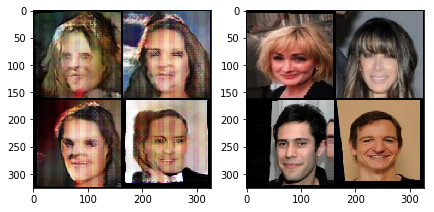

[2/5][600/5628]	Loss_D: 1.0307	Loss_Dec: 2.9101	Aux F1: 0.8264	Loss_Enc: 5312.1729	D(x): 0.4715	D(G(z)): 0.3007
[2/5][700/5628]	Loss_D: 1.0395	Loss_Dec: 2.8914	Aux F1: 0.8267	Loss_Enc: 5347.0663	D(x): 0.5024	D(G(z)): 0.3044
[2/5][800/5628]	Loss_D: 1.0324	Loss_Dec: 2.8973	Aux F1: 0.8268	Loss_Enc: 5375.5435	D(x): 0.4870	D(G(z)): 0.3203
[2/5][900/5628]	Loss_D: 1.0260	Loss_Dec: 2.9111	Aux F1: 0.8267	Loss_Enc: 5376.5550	D(x): 0.4952	D(G(z)): 0.3342
[2/5][1000/5628]	Loss_D: 1.0199	Loss_Dec: 2.9266	Aux F1: 0.8266	Loss_Enc: 5385.5804	D(x): 0.4951	D(G(z)): 0.3714


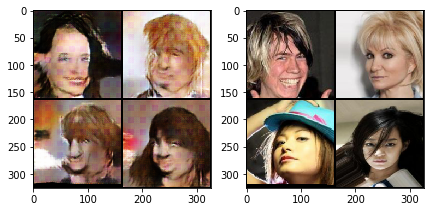

[2/5][1100/5628]	Loss_D: 1.0278	Loss_Dec: 2.9156	Aux F1: 0.8267	Loss_Enc: 5404.8040	D(x): 0.4599	D(G(z)): 0.3440
[2/5][1200/5628]	Loss_D: 1.0308	Loss_Dec: 2.9071	Aux F1: 0.8267	Loss_Enc: 5425.9447	D(x): 0.5418	D(G(z)): 0.3267
[2/5][1300/5628]	Loss_D: 1.0284	Loss_Dec: 2.9050	Aux F1: 0.8268	Loss_Enc: 5425.0255	D(x): 0.4668	D(G(z)): 0.3287
[2/5][1400/5628]	Loss_D: 1.0222	Loss_Dec: 2.9109	Aux F1: 0.8265	Loss_Enc: 5406.3286	D(x): 0.4591	D(G(z)): 0.3617
[2/5][1500/5628]	Loss_D: 1.0194	Loss_Dec: 2.9154	Aux F1: 0.8265	Loss_Enc: 5401.2229	D(x): 0.5042	D(G(z)): 0.3309


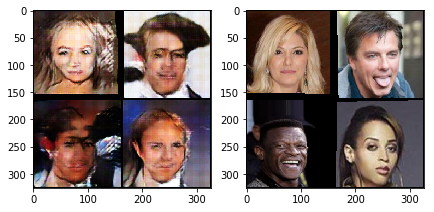

[2/5][1600/5628]	Loss_D: 1.0188	Loss_Dec: 2.9166	Aux F1: 0.8267	Loss_Enc: 5398.6438	D(x): 0.5208	D(G(z)): 0.3175
[2/5][1700/5628]	Loss_D: 1.0143	Loss_Dec: 2.9232	Aux F1: 0.8267	Loss_Enc: 5412.8698	D(x): 0.5143	D(G(z)): 0.3301
[2/5][1800/5628]	Loss_D: 1.0111	Loss_Dec: 2.9264	Aux F1: 0.8268	Loss_Enc: 5424.9522	D(x): 0.5110	D(G(z)): 0.3838
[2/5][1900/5628]	Loss_D: 1.0127	Loss_Dec: 2.9220	Aux F1: 0.8268	Loss_Enc: 5437.9203	D(x): 0.5096	D(G(z)): 0.3289
[2/5][2000/5628]	Loss_D: 1.0142	Loss_Dec: 2.9184	Aux F1: 0.8268	Loss_Enc: 5446.5926	D(x): 0.5091	D(G(z)): 0.3603


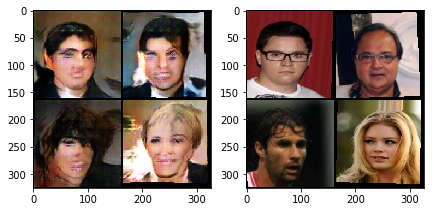

[2/5][2100/5628]	Loss_D: 1.0168	Loss_Dec: 2.9119	Aux F1: 0.8269	Loss_Enc: 5454.2962	D(x): 0.4707	D(G(z)): 0.3433
[2/5][2200/5628]	Loss_D: 1.0173	Loss_Dec: 2.9102	Aux F1: 0.8269	Loss_Enc: 5450.6242	D(x): 0.4411	D(G(z)): 0.3798
[2/5][2300/5628]	Loss_D: 1.0187	Loss_Dec: 2.9044	Aux F1: 0.8270	Loss_Enc: 5468.3677	D(x): 0.4656	D(G(z)): 0.4200
[2/5][2400/5628]	Loss_D: 1.0190	Loss_Dec: 2.9012	Aux F1: 0.8270	Loss_Enc: 5491.7986	D(x): 0.4798	D(G(z)): 0.4246
[2/5][2500/5628]	Loss_D: 1.0175	Loss_Dec: 2.9020	Aux F1: 0.8269	Loss_Enc: 5521.1740	D(x): 0.5232	D(G(z)): 0.3506


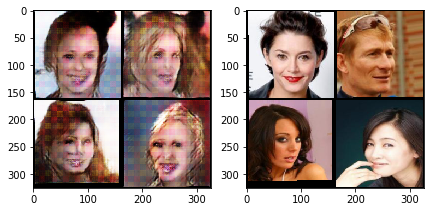

[2/5][2600/5628]	Loss_D: 1.0177	Loss_Dec: 2.8990	Aux F1: 0.8270	Loss_Enc: 5545.0187	D(x): 0.3850	D(G(z)): 0.3692
[2/5][2700/5628]	Loss_D: 1.0188	Loss_Dec: 2.8963	Aux F1: 0.8271	Loss_Enc: 5555.3562	D(x): 0.4266	D(G(z)): 0.3459


In [ ]:
train(net, n_epochs=5, train_loader=train_loader, margin=0.40, plot_images=500)

In [ ]:
train(net, n_epochs=5, train_loader=train_loader, margin=0.4)

In [ ]:
train(net, n_epochs=5, train_loader=train_loader, margin=0.40)

In [ ]:
train(net, n_epochs=10, train_loader=train_loader, margin=0.38)

In [ ]:
train(net, n_epochs=5, train_loader=train_loader, margin=0.40)

In [ ]:
train(net, n_epochs=10, train_loader=train_loader, margin=0.38)

In [ ]:
with torch.no_grad():
    for (inputs, b_labels) in train_loader:
#     inputs, labels = next(iter(train_loader))
        inputs = inputs.cuda()
        
        output, out_labels, classes, fm_r, mus, variances = net(inputs)

        # get the predicted attributes
        preds = torch.round(classes).squeeze().detach().cpu().numpy()        
        
        image_1_attrs = image_labels.columns[1:][preds[0] == 1]
        image_2_attrs = image_labels.columns[1:][preds[1] == 1]
        image_3_attrs = image_labels.columns[1:][preds[2] == 1]
        image_4_attrs = image_labels.columns[1:][preds[3] == 1]
        
        b_labels = b_labels.detach().cpu().numpy()
        image_1_gt = image_labels.columns[1:][b_labels[0] == 1]
        image_2_gt = image_labels.columns[1:][b_labels[1] == 1]
        image_3_gt = image_labels.columns[1:][b_labels[2] == 1]
        image_4_gt = image_labels.columns[1:][b_labels[3] == 1]
        
        inputs = (inputs * 0.5) + 0.5
        fig, ax = plt.subplots(2, 2, figsize=(7,7))
        ax[0,0].imshow(inputs[0].detach().cpu().permute(1,2,0))
        ax[0,1].imshow(inputs[1].detach().cpu().permute(1,2,0))
        ax[1,0].imshow(inputs[2].detach().cpu().permute(1,2,0))
        ax[1,1].imshow(inputs[3].detach().cpu().permute(1,2,0))
        plt.show()   
        
        print("Pred Attrs 1:", image_1_attrs)
        print("GT Attrs 1:", image_1_gt)
        print()
        print("Pred Attrs 2:", image_2_attrs)
        print("GT Attrs 2:", image_2_gt)
        print()
        print("Pred Attrs 3:", image_3_attrs)
        print("GT Attrs 3:", image_3_gt)
        print()
        print("Pred Attrs 4:", image_4_attrs)
        print("GT Attrs 4:", image_4_gt)
        print()
        break

In [ ]:
with torch.no_grad():
    inputs, _ = next(iter(test_loader))
    inputs = inputs.cuda()
    
    fake, out_labels, classes, out_layer, code, logvar = net(inputs)
    
    train_batch = inputs.shape[0]
    
    out_layer_predicted = fake[:train_batch]
    out_layer_original = fake[train_batch:-train_batch]
    out_layer_sampled = fake[-train_batch:]
    
    fig, ax = plt.subplots(1, 2, figsize=(12,12))
    ax[0].imshow(np.transpose(vutils.make_grid(out_layer_predicted.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[0].set_title("Non-Sampled")
#     ax[1].imshow(np.transpose(vutils.make_grid(out_layer_sampled.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
#     ax[1].set_title("Sampled")
    ax[1].imshow(np.transpose(vutils.make_grid(inputs.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[1].set_title("Original")
    plt.show()   

print("Code mean:", code.mean().item())
print("Code max:", code.max().item())
print("Code min:", code.min().item())
print("Code var:", code.var().item())
print()

# print("SCode mean:", code_s.mean().item())
# print("SCode max:", code_s.max().item())
# print("SCode min:", code_s.min().item())
# print("SCode var:", code_s.var().item())
# print()

print("Logvar mean:", logvar.mean().item())
print("Logvar var:", logvar.var().item())
print("Logvar Exp:", logvar.exp().mean().item())